## Long Short-Term Memory (LSTMs)

In [2]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
# Import feature and target columns
df = pickle.load(open("../../common/pima.p", "rb"))
target_columns = pickle.load(open("../../common/feature_cols.p", "rb"))
split_size = pickle.load(open("../../common/split_size.p", "rb"))
n_past = pickle.load(open("../../common/n_past.p", "rb"))
n_future = pickle.load(open("../../common/n_future.p", "rb"))

### Perform Cross Validation

### Train the model

In [4]:
# Create function to prepare data sequences
def create_sequences(input_data, n_past, n_future, target_column_index):
    X, y = [], []
    for window_start in range(len(input_data) - n_past - n_future + 1):
        past_end = window_start + n_past
        future_end = past_end + n_future
        X.append(input_data[window_start:past_end, :])
        y.append(input_data[past_end:future_end, target_column_index])
    return np.array(X), np.array(y)

In [5]:
# Initialize a dictionary to store the scalers
scalers = {}

# Scale each target column individually and store the scaler
scaled_df = df[target_columns].copy()
for i, target_col in enumerate(target_columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df[target_col] = scaler.fit_transform(df[[target_col]].values)
    scalers[target_col] = scaler

# Convert the DataFrame back to a numpy array
scaled_df = scaled_df.values

# Prepare the training and test sets
train_size = int(len(scaled_df) * split_size)
test_size = len(scaled_df) - train_size
train, test = scaled_df[:train_size, :], scaled_df[train_size:, :]

# Get test statuses data
statuses_df = df[["status"]].copy().values
status_size = train_size + n_past
status_test = statuses_df[status_size:, :].copy()
statuses = status_test[:, -1]

In [6]:
# Train models and make initial predictions
models = {}
initial_predictions = {}
for i, target_col in enumerate(target_columns):
    # Prepare sequences
    X_train, y_train = create_sequences(train, n_past, n_future, i)
    X_test, y_test = create_sequences(test, n_past, n_future, i)

    # Design LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_past, X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(n_future))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    models[target_col] = model

    # Initial prediction
    initial_predictions[target_col] = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


### Predict the value

In [7]:
# Recursive multi-step forecast
n_steps = len(test) - n_past
predictions = {col: [] for col in target_columns}
for step in range(n_steps):
    current_seq = test[step:step + n_past, :]
    next_seq = current_seq.copy()  # copy of the current sequence to be updated with predictions
    for i, target_col in enumerate(target_columns):
        model = models[target_col]
        pred = model.predict(current_seq.reshape(1, n_past, -1))[0,0]
        predictions[target_col].append(pred)
        next_seq[-1, i] = pred  # update next sequence with the prediction
    current_seq = next_seq  # use the sequence updated with predictions for the next step

1/1 [==============================] - 0s 25ms/step


### Visualize the model

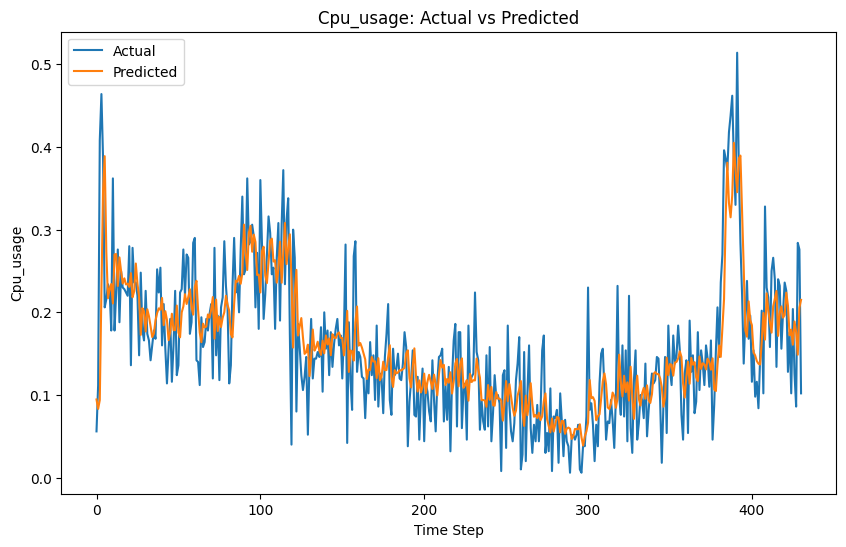

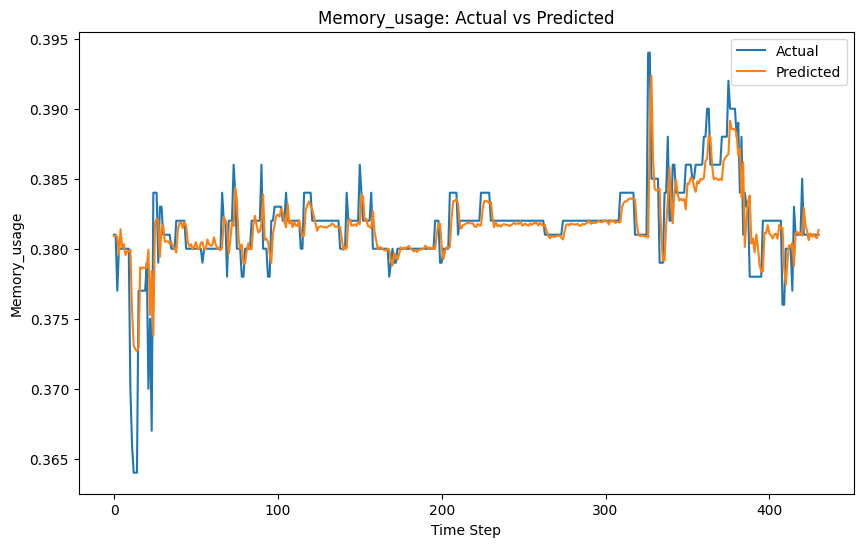

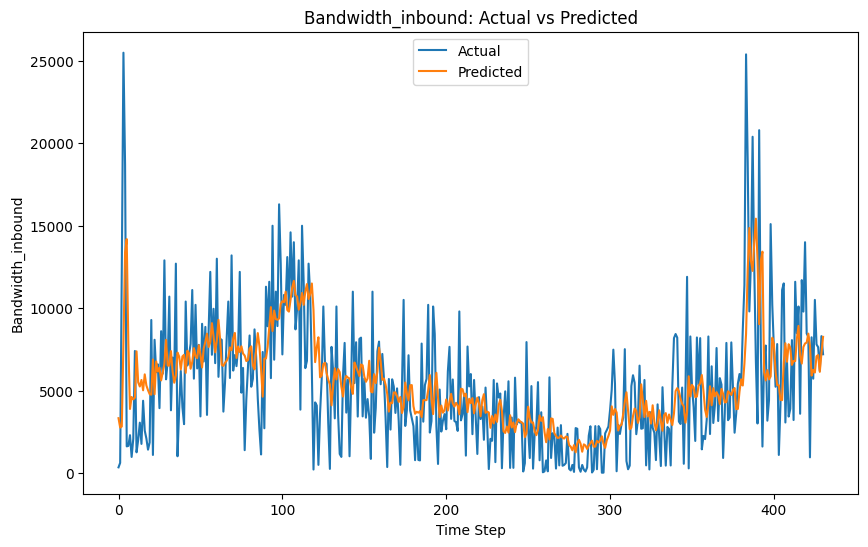

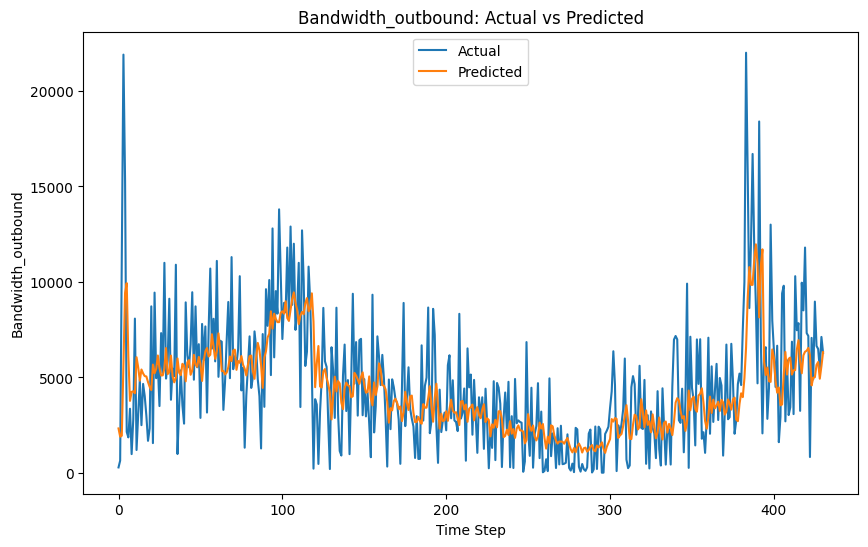

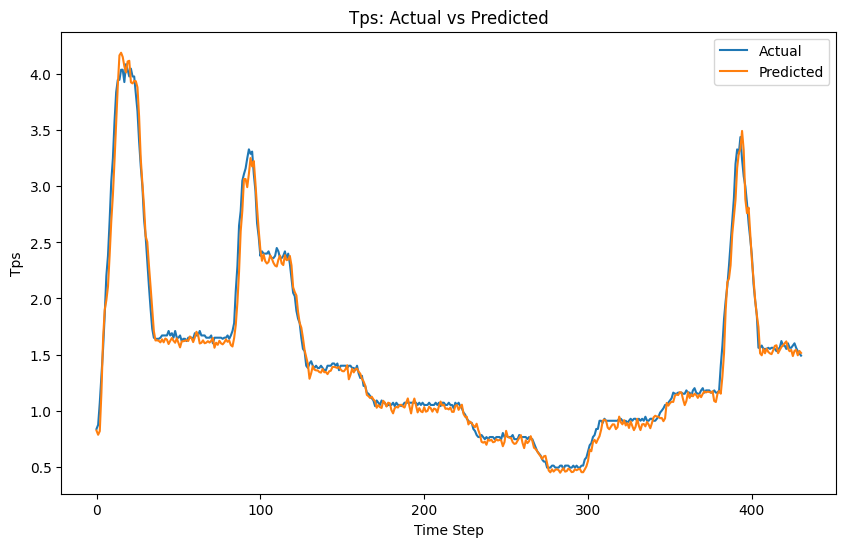

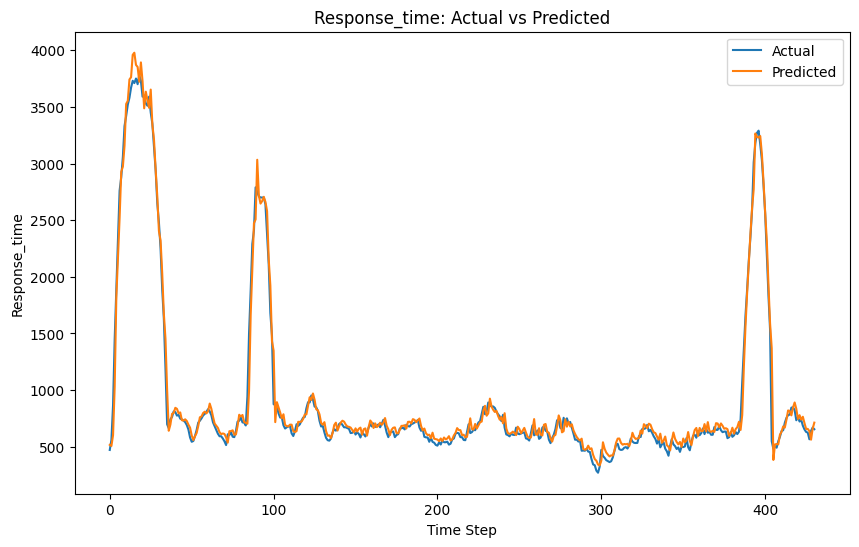

In [8]:
# Plot actual vs predicted
for i, target_col in enumerate(target_columns):
    plt.figure(figsize=(10, 6))
    plt.plot(scalers[target_col].inverse_transform(test[n_past:, i].reshape(-1,1)), label='Actual')
    plt.plot(scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1)), label='Predicted')
    plt.title(f'{target_col.capitalize()}: Actual vs Predicted')
    plt.ylabel(f'{target_col.capitalize()}')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()

In [14]:
inverse_transform_predictions = {}

for i, target_col in enumerate(target_columns):
    inverse_transform_predictions[target_col] = scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1)).flatten()

# Let's convert it to DataFrame to check the result
df_inverse_predictions = pd.DataFrame(inverse_transform_predictions)
np_predictions = pd.DataFrame(df_inverse_predictions.values, columns=target_columns)

print(np_predictions.head())
print(len(np_predictions))

   cpu_usage  memory_usage  bandwidth_inbound  bandwidth_outbound       tps   
0   0.094582      0.380912        3321.570801         2328.743408  0.821540  \
1   0.083226      0.380939        2751.427002         1897.020386  0.784159   
2   0.093898      0.380853        2817.742676         1948.762085  0.816824   
3   0.227059      0.379559        7872.604004         5678.750000  1.160578   
4   0.346659      0.381393       13383.971680         9419.245117  1.633237   

   response_time  
0     516.774658  
1     507.179077  
2     602.246216  
3    1031.871704  
4    1821.293945  
431


### Export the model

In [15]:
pickle.dump(models, open('../../models/multivariate/lstm/models.p', 'wb'))
pickle.dump(scalers, open('../../models/multivariate/lstm/_scalers.p', 'wb'))
pickle.dump(np_predictions, open('../../models/multivariate/lstm/_predictions_result.p', 'wb'))
pickle.dump(statuses, open('../../models/multivariate/lstm/_statuses_test.p', 'wb'))